In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures=False 

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
from dataset import GermanCreditDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [32]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet
from sklearn.metrics import accuracy_score, classification_report


dataset = GermanCreditDataset()
input_dim = dataset.get_dataframe().shape[1] - 1
seed = 102
torch.manual_seed(seed)

counterfactual_algorithms = [
    'DiCE',
    # 'DisCount',
]

experiment = Benchmarking(
    dataset=GermanCreditDataset(),
    models=[
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        "independent_X_counterfactual",
        "independent_X_train",
        "joint_probability_X_counterfactual",
        "joint_probability_X_train",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'kl_divergence',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()


logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")




INFO:root:PyTorchDNN accuracy: 0.7366666666666667
INFO:root:PyTorchRBFNet accuracy: 0.7366666666666667
INFO:root:RandomForestClassifier accuracy: 0.7366666666666667
INFO:root:GradientBoostingClassifier accuracy: 0.7366666666666667
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with DiCE
100%|██████████| 50/50 [02:53<00:00,  3.47s/it]
INFO:root:Computing PyTorchRBFNet counterfactuals with DiCE
100%|██████████| 50/50 [05:04<00:00,  6.09s/it]
INFO:root:Computing RandomForestClassifier counterfactuals with DiCE
100%|██████████| 50/50 [10:16<00:00, 12.33s/it]
INFO:root:Computing GradientBoostingClassifier counterfactuals with DiCE
100%|██████████| 50/50 [05:53<00:00,  7.07s/it]


In [33]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchDNN using independent_X_counterfactual with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([0.10249105, 0.06555876, 0.0188803 , 0.05676577, 0.03574632,
       0.12899792, 0.03901804, 0.3211803 , 0.07454262])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.09878611, -0.00962256,  0.02002359,  0.01922934,  0.10261578,
        0.03777468,  0.06565061,  0.51091618, -0.00799123])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([0.10830899, 0.01694006, 0.03193728, 0.02198619, 0.02854122,
       0.19448913, 0.17002127, 0.23766659, 0.02478123])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.17755417,  0.08297264,  0.05159354,  0.14776998,  0.03146657,
        0.23740576,  0.07177435, -0.03711   , -0.07224559])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.09537826,  0.06834478,  0.05492944,  0.00757514, -0.15466165,
        0.01589844,  0.0861024 ,  0.2654103 ,  0.18382013])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([0.03309514, 0.03397005, 0.07559239, 0.00403444, 0.03719166,
       0.

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.0524107 ,  0.02798257,  0.00455011,  0.04078208,  0.09348967,
        0.17782213, -0.02951699,  0.32242234,  0.02265478])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.04566354, -0.0211749 ,  0.00451886,  0.0015339 ,  0.10200518,
        0.04977467,  0.00581089,  0.53502886, -0.0163622 ])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.03878134, -0.00217909,  0.01312194, -0.01619214,  0.07801026,
        0.3688587 ,  0.02671629,  0.19289241,  0.00407858])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07987724,  0.0326066 ,  0.03621714,  0.13434996,  0.07502274,
        0.27817075, -0.00082948,  0.02613003, -0.10094725])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.04304082,  0.03451557,  0.04573125, -0.0062108 , -0.12114938,
        0.10001743, -0.03835923,  0.29291527,  0.14171264])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.03728928,  0.01416412,  0.05271878, -0.02725514,

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.0359374 ,  0.049864  ,  0.02521953,  0.03745391,  0.13719159,
        0.04689619,  0.0191607 ,  0.52017124, -0.02869237])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.01243276,  0.01232673,  0.01351584,  0.01116766,  0.05023718,
        0.05101881,  0.08053678,  0.44637046, -0.08500086])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.02743616,  0.02064441,  0.01444752, -0.01449402,  0.00786761,
        0.01332689,  0.02207023,  0.18898419,  0.01489805])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.00840112,  0.02160644, -0.00283808,  0.01753729,  0.01398677,
        0.03208095,  0.01592033, -0.03697971,  0.01253636])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.01393455, -0.02981222,  0.01288116, -0.00280689,  0.02375054,
        0.07307112,  0.01990799, -0.10749546,  0.0214433 ])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.00685743, -0.00602212,  0.01502721,  0.01526712,

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.0461762 ,  0.02932744,  0.03205129,  0.01377327,  0.14262332,
        0.08768118, -0.07094418,  0.65211362, -0.04561335])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.01436021,  0.01157813,  0.01201192, -0.00817804,  0.06524431,
        0.08791447, -0.01187695,  0.53222332, -0.08716299])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-0.0416316 ,  0.01377365,  0.01449983, -0.0133903 ,  0.00299394,
        0.05020868, -0.01191234,  0.24131455,  0.00796131])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.0103066 ,  0.03367833, -0.01398254,  0.00617554,  0.01800096,
        0.07864335, -0.004384  , -0.02755272,  0.00487496])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.01926333, -0.01215912,  0.00999888, -0.01094977,  0.0214185 ,
        0.11761982, -0.00731905, -0.09871586,  0.00922637])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 8.20115265e-03, -8.70546480e-05,  1.27798426e-02, 

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.10085238,  0.01228571,  0.00208571, -0.00048095,  0.0525    ,
        0.10066667,  0.06265238,  0.26895238,  0.01648571])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.02393333,  0.00814286,  0.06040476, -0.01755238,  0.03141429,
        0.12315238, -0.05738095,  0.27397143,  0.06991429])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.06210714,  0.00540714,  0.02358571, -0.00349286,  0.04074048,
        0.13052143, -0.00600714,  0.30099286,  0.06214524])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07205   ,  0.07097381,  0.01009048,  0.06695476, -0.02055   ,
        0.11370238,  0.14832857, -0.07512619,  0.02957619])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.31824762,  0.02880714,  0.01867619,  0.00135714,  0.00149524,
       -0.08305238,  0.16798095,  0.05320952,  0.00927857])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07355   ,  0.0507    , -0.00142857, -0.01180238,

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07648333,  0.01247143, -0.00335476, -0.00455   ,  0.0625119 ,
        0.21374524,  0.09239762,  0.23329762,  0.00299762])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.03246429, -0.00689762,  0.0446    , -0.00243571,  0.03030238,
        0.24601667, -0.03871667,  0.25259762,  0.02806905])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.0362619 , -0.00740476,  0.01262857, -0.00321905,  0.04604762,
        0.26162857,  0.01519524,  0.2991619 ,  0.0257    ])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.07054286,  0.0747    , -0.00271905,  0.08023095, -0.01242381,
        0.23293333,  0.0891    , -0.05959048,  0.01322619])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.37917619,  0.02688333,  0.00935   , -0.00445238,  0.01094048,
       -0.06294762,  0.1019381 ,  0.12398571,  0.00112619])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 0.06433095,  0.04324286,  0.00379286, -0.01431905,

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 3.22033579e-02,  9.94740545e-18, -1.44378249e-17,  9.22267184e-18,
        4.09829318e-02,  5.01933171e-02,  4.45338731e-03,  1.56554454e-01,
       -2.51146418e-04])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 3.22095034e-02, -1.89036790e-17,  1.50103119e-18, -1.19669754e-17,
        4.09829318e-02,  5.45499828e-02, -1.65491752e-02,  1.73194205e-01,
       -2.51146418e-04])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 3.22033579e-02, -2.24636827e-17, -1.27785122e-16, -1.51861272e-16,
        4.09829318e-02,  4.99588452e-02,  4.74239195e-02,  1.11875413e-01,
        1.69183408e-03])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 9.31217316e-03,  3.36309542e-17,  2.37515016e-17,  1.67314135e-17,
        1.41112031e-02,  4.38243952e-02,  3.70412785e-02, -5.20383481e-03,
       -2.40488725e-04])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-1.61557236e-02, -2.10761284e-17, -4.07613112e-17,  1.6957

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 2.39922632e-02, -3.38983741e-17,  1.45125611e-03,  5.91635659e-17,
        1.33902482e-02,  1.00590285e-01,  1.24956133e-02,  1.60442053e-01,
        0.00000000e+00])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 2.39931328e-02, -5.15075346e-18,  1.45125611e-03,  5.30883164e-17,
        1.33902482e-02,  1.03294394e-01, -6.70668972e-03,  1.76939377e-01,
       -5.55111512e-17])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 2.39553279e-02, -4.17117287e-17,  1.45125611e-03, -2.64339248e-18,
        1.33902482e-02,  1.03156627e-01,  5.52114432e-02,  1.11352016e-01,
        3.84480009e-03])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([ 1.61441996e-02,  2.21160950e-17,  5.50899341e-18,  1.60123555e-17,
        7.82464661e-04,  6.88203158e-02,  4.56846316e-02, -4.36146845e-03,
        0.00000000e+00])
INFO:shap:num_full_subsets = 4
INFO:shap:phi = array([-1.75183210e-02, -1.18914008e-17,  1.49199738e-03,  6.1177

In [43]:
experiment.distance_metrics = [
        'optimal_transport',
        'mean_difference',
        'kl_divergence',
        # 'max_mean_discrepancy',
    ]

In [59]:
with open(r"pickles/distance_results.pickle", "rb") as input_file:
    experiment.distance_results.update(pickle.load(input_file))

In [44]:
import pickle 
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 25, 50, 75, 100, 150, 200, 250, 300, 400],
    trials_num=100,
)

with open(r"pickles/distance_results.pickle", "rb") as input_file:
    experiment.distance_results.update(pickle.load(input_file))

with open(r"pickles/distance_results.pickle", "wb") as output_file:
    pickle.dump(experiment.distance_results, output_file)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, independent_X_counterfactual)
100%|██████████| 100/100 [00:01<00:00, 75.19it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, independent_X_counterfactual)
100%|██████████| 100/100 [00:00<00:00, 229.40it/s]
INFO:root:Computing kl_divergence for (PyTorchDNN, DiCE, independent_X_counterfactual)
100%|██████████| 100/100 [00:00<00:00, 227.55it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, independent_X_train)
100%|██████████| 100/100 [00:01<00:00, 96.92it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, independent_X_train)
100%|██████████| 100/100 [00:00<00:00, 222.98it/s]
INFO:root:Computing kl_divergence for (PyTorchDNN, DiCE, independent_X_train)
100%|██████████| 100/100 [00:00<00:00, 204.25it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, joint_probability_X_counterfactual)
100%|██████████|

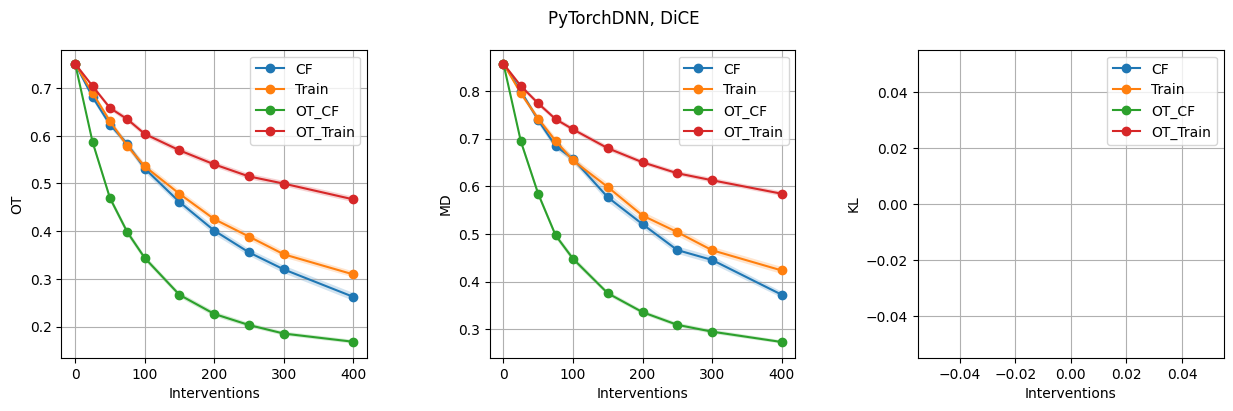

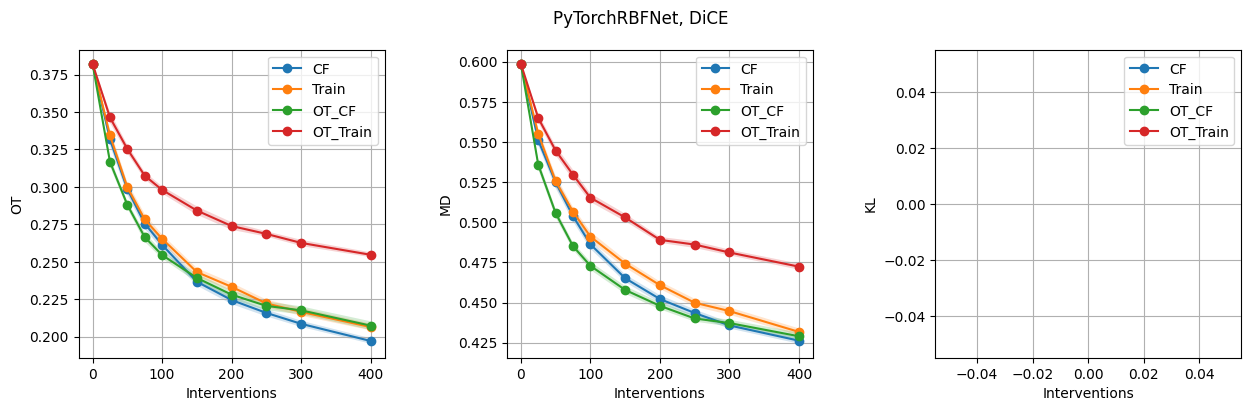

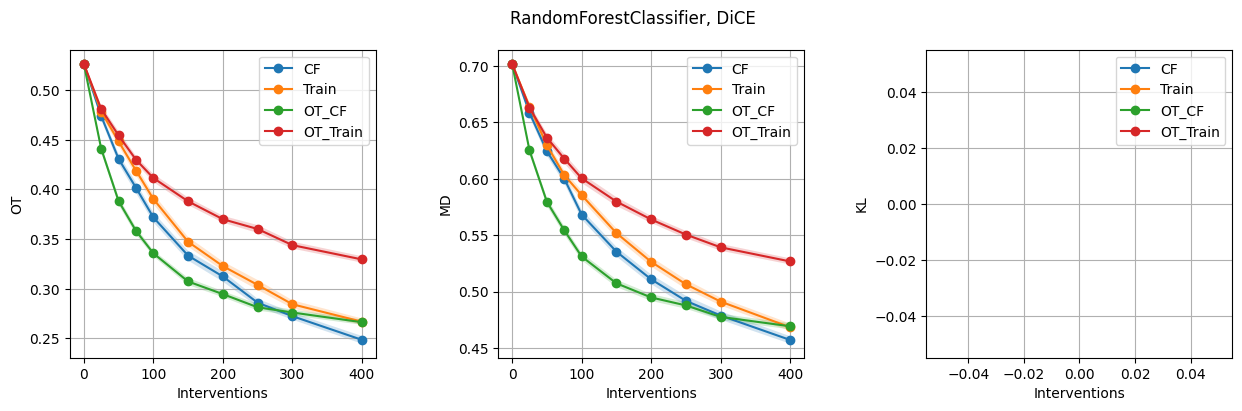

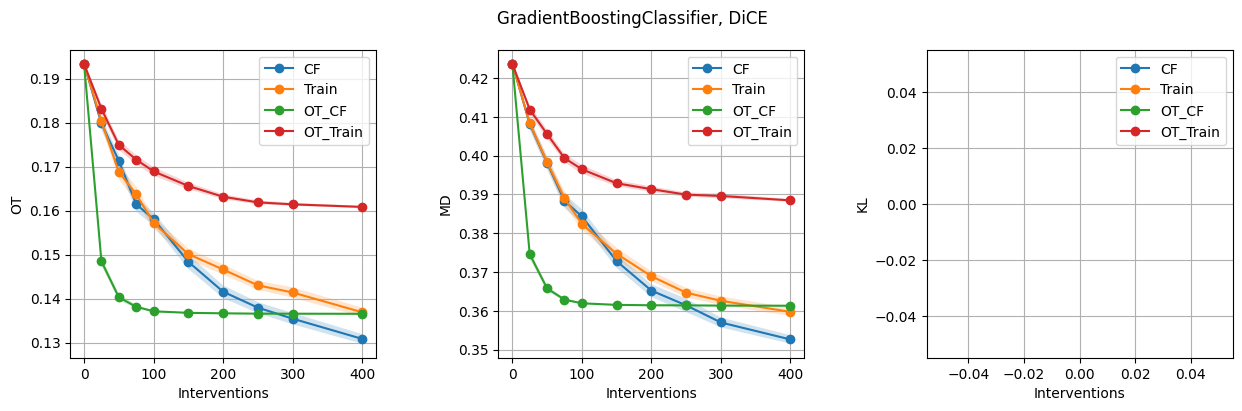

In [60]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=True)

In [46]:

aaa.update(experiment.distance_results)